In [1]:
library(grid)
library(rpart)
library(rpart.plot)
library(partykit)
library(lattice)
library(ggplot2)
library(caret)
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
set.seed(1)

In [3]:
jRoadType <- c("都市間高速", "都市高速", "有料道路", "国道", "県道", "主要地方道", "一般道1、一般道2、一般道3", "その他")
jHighSpeeds <- c("都市間高速", "都市高速", "有料道路")

In [4]:
printf <- function(...) cat(sprintf(...))

In [5]:
# valid columns when high speed
invalids <- c('Time', 'Longitude', 'Latitude', 'Brake', 'Accel', 'RoadType', 'flag')
isValidColumn <- function(x) ! x %in% invalids

In [6]:
CV <- function(dfx, expr, verbose=FALSE) {        
    folds <- createFolds(dfx$flag, k=5)
    
    count <- 1
    errs <- c()
    reds <- c()
    blues <- c()
    for (ids in folds) {
        train <- dfx[-ids, ]
        test <- dfx[ids, ]
        # fit <- rpart(expr, data=train, method="class")
        fit <- rpart(expr, data=train, method="class", cp=0.022)
        p <- predict(fit, newdata=test)
        predictedFlags <- colnames(p)[max.col(p, ties.method = "first")]
        
        if (verbose) {
            printf("Fold%d\n", count)
            result <- correctVsPredict(test, predictedFlags, verbose)
            reds <- c(reds, result[1])
            blues <- c(blues, result[2])
            count <- count + 1
            printf("\n")
        } else {
            result <- correctVsPredict(test, predictedFlags, verbose)
            reds <- c(reds, result[1])
            blues <- c(blues, result[2])
        }
        
        nerr <- sum((predictedFlags == test$flag) == FALSE)
        errs <- c(errs, nerr / nrow(test))
    }
    
    return(c(mean(errs), mean(reds), mean(blues)))
}

In [7]:
correctVsPredict <- function(test, predictedFlags, verbose=FALSE) {    
    # for All
    # nTests <- nrow(test)
    # nCorrectAll <- sum((predictedFlags == test$flag) == TRUE)
    # printf("As fo All: correct/all = %d/%d = %f\n", nCorrectAll, nTests, nCorrectAll / nTests)
    
    # for Red
    predictedRedRows <- test[predictedFlags == "Red", ]
    nCorrectReds <- sum((predictedRedRows$flag == 'Red') == TRUE)
    nPredictedReds <- nrow(predictedRedRows)
    
    # for Blue
    predictedBlueRows <- test[predictedFlags == "Blue", ]
    nCorrectBlues <- sum((predictedBlueRows$flag == 'Blue') == TRUE)
    nPredictedBlues <- nrow(predictedBlueRows)
        
    if (verbose) {
        printf("As for Red: correct/predict = %d/%d = %f\n", nCorrectReds, nPredictedReds, nCorrectReds / nPredictedReds)
        printf("As for Blue: correct/predict = %d/%d = %f\n", nCorrectBlues, nPredictedBlues, nCorrectBlues / nPredictedBlues)  
    }    
    
    c(nCorrectReds/nPredictedReds, nCorrectBlues/nPredictedBlues)
}

In [8]:
printRedRatios <- function(dfx) {
    nRed <- nrow(dfx[dfx$flag == "Red", ])
    nAll <- nrow(dfx)
    printf("Red/All = %d/%d = %f\n", nRed, nAll, nRed/nAll)
    printf("1 - Red/All = %d/%d = %f\n", nAll - nRed, nAll, 1 - nRed/nAll)
}

In [9]:
createFormula <- function(invalids, allFeatures) {
    isValidColumn <- function(x) ! x %in% invalids
    
    features <- Filter(isValidColumn, allFeatures)
    return(paste("flag ~ ", paste(features, collapse=" + ")))
}

# Predict Reds

In [10]:
df3 <- read.csv("../data/middle/sp4.csv", stringsAsFactors=FALSE)

In [11]:
df3$flag[df3$flag == "RedA"] <- "Red"
df3$flag[df3$flag == "RedB"] <- "Red"
df3$flag[df3$flag == "BlueA"] <- "Blue"
df3$flag[df3$flag == "BlueB"] <- "Blue"
df3$flag <- as.factor(df3$flag)

In [12]:
allFeatures <- c(colnames(df3))

In [13]:
roadTypes <- unique(df3$RoadType)

In [14]:
for (i in roadTypes) {
    printf("RoadType: %d (%s)\n", i, jRoadType[i+1])
    dfx <- df3[df3$RoadType == i, ]
    expr <- createFormula(invalids, allFeatures)
    result <- CV(dfx, expr, verbose=FALSE)
    printRedRatios(dfx)
    printf("Red: Mean correct/predict = %f\n", result[2])
    printf("Blue: Mean correct/predict = %f\n", result[3])
    printf("CV value: %f", result[1])
    printf("\n\n")
}

RoadType: 7 (その他)
Red/All = 25/27 = 0.925926
1 - Red/All = 2/27 = 0.074074
Red: Mean correct/predict = 0.933333
Blue: Mean correct/predict = NaN
CV value: 0.066667

RoadType: 6 (一般道1、一般道2、一般道3)
Red/All = 90/189 = 0.476190
1 - Red/All = 99/189 = 0.523810
Red: Mean correct/predict = 0.672554
Blue: Mean correct/predict = 0.646255
CV value: 0.354623

RoadType: 4 (県道)
Red/All = 36/71 = 0.507042
1 - Red/All = 35/71 = 0.492958
Red: Mean correct/predict = 0.469841
Blue: Mean correct/predict = 0.425952
CV value: 0.547619

RoadType: 5 (主要地方道)
Red/All = 154/303 = 0.508251
1 - Red/All = 149/303 = 0.491749
Red: Mean correct/predict = 0.595961
Blue: Mean correct/predict = 0.585389
CV value: 0.409126

RoadType: 3 (国道)
Red/All = 202/324 = 0.623457
1 - Red/All = 122/324 = 0.376543
Red: Mean correct/predict = 0.681077
Blue: Mean correct/predict = 0.502318
CV value: 0.373125

RoadType: 0 (都市間高速)
Red/All = 55/81 = 0.679012
1 - Red/All = 26/81 = 0.320988
Red: Mean correct/predict = 0.695455
Blue: Mean corr

In [15]:
fit3 <- rpart(expr, data=df3, method="class")

In [16]:
fit3$cptable[which.min(fit3$cptable[,"xerror"]),"CP"]

[1] 0.01781737

In [17]:
printcp(fit3)


Classification tree:
rpart(formula = expr, data = df3, method = "class")

Variables actually used in tree construction:
 [1] AccelerationSpeed Curve100          Curve150          CurveAverage     
 [5] DistSignal        LaneCount         MaxSpeed          Pitch            
 [9] RiskFactor        Speed             SteeringAngle     TimeHeadway      

Root node error: 449/1042 = 0.4309

n= 1042 

        CP nsplit rel error  xerror     xstd
1 0.037862      0   1.00000 1.00000 0.035602
2 0.033408      4   0.84410 0.97105 0.035465
3 0.018931      5   0.81069 0.91759 0.035151
4 0.017817      7   0.77283 0.91537 0.035136
5 0.014477      8   0.75501 0.93987 0.035292
6 0.011136     12   0.69710 0.93541 0.035265
7 0.010000     19   0.61915 0.93987 0.035292


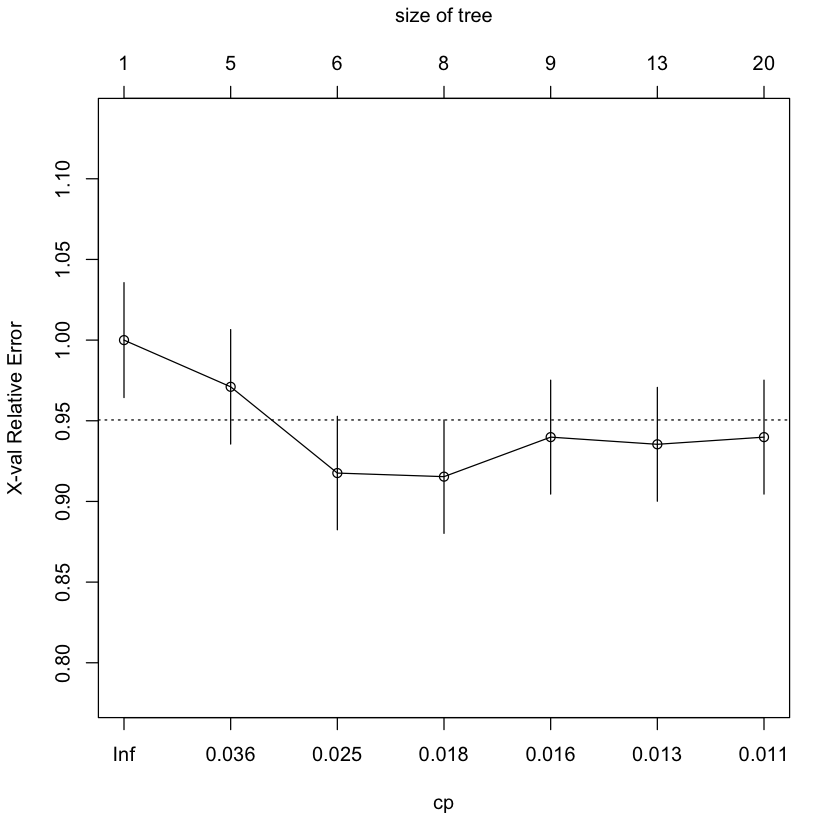

In [18]:
plotcp(fit3)

In [19]:
summary(fit3)

Call:
rpart(formula = expr, data = df3, method = "class")
  n= 1042 

          CP nsplit rel error    xerror       xstd
1 0.03786192      0 1.0000000 1.0000000 0.03560167
2 0.03340757      4 0.8440980 0.9710468 0.03546495
3 0.01893096      5 0.8106904 0.9175947 0.03515108
4 0.01781737      7 0.7728285 0.9153675 0.03513625
5 0.01447661      8 0.7550111 0.9398664 0.03529164
6 0.01113586     12 0.6971047 0.9354120 0.03526465
7 0.01000000     19 0.6191537 0.9398664 0.03529164

Variable importance
      TimeHeadway        RiskFactor          MaxSpeed             Speed 
               12                11                 8                 7 
         Curve100 AccelerationSpeed      CurveAverage          Curve150 
                7                 6                 6                 6 
            Curve     SteeringAngle             Pitch   TimeToCollision 
                6                 5                 5                 4 
    AheadDistance        DistSignal   AverageVelocity         L

In [20]:
set.seed(1)

In [21]:
roadTypes

[1] 7 6 4 5 3 0 2

# Threshold = 10

In [22]:
# Not Use
dfx <- df3[df3$RoadType == i, ]
folds <- createFolds(dfx$flag, k=5)

In [23]:
i = 6
threshold <- 10
printf("RoadType: %d (%s)\n", i, jRoadType[i+1])
dfx <- df3[df3$RoadType == i, ]
expr <- createFormula(invalids, allFeatures)
dfx1 <- dfx %>% filter( AverageVelocity <= threshold)
dfx2 <- dfx %>% filter(AverageVelocity >   threshold)
        
result1 <- CV(dfx1, expr, verbose=TRUE)        
printf("AverageVelocity <= %d:\n", threshold)
printRedRatios(dfx1)        
printf("Red: Mean correct/predict = %f\n", result1[2])
printf("Blue: Mean correct/predict = %f\n", result1[3])
printf("CV value: %f", result1[1])        
printf("\n\n")
        
result2 <- CV(dfx2, expr, verbose=TRUE)        
printf("AverageVelocity > %d:\n", threshold)
printRedRatios(dfx2)
printf("Red: Mean correct/predict = %f\n", result2[2])
printf("Blue: Mean correct/predict = %f\n", result2[3])
printf("CV value: %f", result2[1])       
printf("\n\n")

RoadType: 6 (一般道1、一般道2、一般道3)
Fold1
As for Red: correct/predict = 2/4 = 0.500000
As for Blue: correct/predict = 1/1 = 1.000000

Fold2
As for Red: correct/predict = 0/2 = 0.000000
As for Blue: correct/predict = 1/4 = 0.250000

Fold3
As for Red: correct/predict = 1/4 = 0.250000
As for Blue: correct/predict = 0/1 = 0.000000

Fold4
As for Red: correct/predict = 2/3 = 0.666667
As for Blue: correct/predict = 2/3 = 0.666667

Fold5
As for Red: correct/predict = 0/2 = 0.000000
As for Blue: correct/predict = 1/3 = 0.333333

AverageVelocity <= 10:
Red/All = 12/27 = 0.444444
1 - Red/All = 15/27 = 0.555556
Red: Mean correct/predict = 0.283333
Blue: Mean correct/predict = 0.450000
CV value: 0.633333

Fold1
As for Red: correct/predict = 8/15 = 0.533333
As for Blue: correct/predict = 9/17 = 0.529412

Fold2
As for Red: correct/predict = 7/13 = 0.538462
As for Blue: correct/predict = 11/20 = 0.550000

Fold3
As for Red: correct/predict = 9/12 = 0.750000
As for Blue: correct/predict = 14/20 = 0.700000

Fol

In [24]:
i = 4
threshold <- 10
printf("RoadType: %d (%s)\n", i, jRoadType[i+1])
dfx <- df3[df3$RoadType == i, ]
expr <- createFormula(invalids, allFeatures)
dfx1 <- dfx %>% filter( AverageVelocity <= threshold)
dfx2 <- dfx %>% filter(AverageVelocity >   threshold)
        
result1 <- CV(dfx1, expr, verbose=TRUE)        
printf("AverageVelocity <= %d:\n", threshold)
printRedRatios(dfx1)        
printf("Red: Mean correct/predict = %f\n", result1[2])
printf("Blue: Mean correct/predict = %f\n", result1[3])
printf("CV value: %f", result1[1])        
printf("\n\n")
        
result2 <- CV(dfx2, expr, verbose=TRUE)        
printf("AverageVelocity > %d:\n", threshold)
printRedRatios(dfx2)
printf("Red: Mean correct/predict = %f\n", result2[2])
printf("Blue: Mean correct/predict = %f\n", result2[3])
printf("CV value: %f", result2[1])       
printf("\n\n")

RoadType: 4 (県道)
Fold1
As for Red: correct/predict = 1/1 = 1.000000
As for Blue: correct/predict = 3/6 = 0.500000

Fold2
As for Red: correct/predict = 4/6 = 0.666667
As for Blue: correct/predict = 0/0 = NaN

Fold3
As for Red: correct/predict = 1/1 = 1.000000
As for Blue: correct/predict = 2/4 = 0.500000

Fold4
As for Red: correct/predict = 0/1 = 0.000000
As for Blue: correct/predict = 2/5 = 0.400000

Fold5
As for Red: correct/predict = 1/3 = 0.333333
As for Blue: correct/predict = 1/3 = 0.333333

AverageVelocity <= 10:
Red/All = 17/30 = 0.566667
1 - Red/All = 13/30 = 0.433333
Red: Mean correct/predict = 0.600000
Blue: Mean correct/predict = NaN
CV value: 0.499048

Fold1
As for Red: correct/predict = 2/4 = 0.500000
As for Blue: correct/predict = 3/5 = 0.600000

Fold2
As for Red: correct/predict = 4/4 = 1.000000
As for Blue: correct/predict = 5/5 = 1.000000

Fold3
As for Red: correct/predict = 1/2 = 0.500000
As for Blue: correct/predict = 3/6 = 0.500000

Fold4
As for Red: correct/predict

In [25]:
i = 5
threshold <- 10
printf("RoadType: %d (%s)\n", i, jRoadType[i+1])
dfx <- df3[df3$RoadType == i, ]
expr <- createFormula(invalids, allFeatures)
dfx1 <- dfx %>% filter( AverageVelocity <= threshold)
dfx2 <- dfx %>% filter(AverageVelocity >   threshold)
        
result1 <- CV(dfx1, expr, verbose=TRUE)        
printf("AverageVelocity <= %d:\n", threshold)
printRedRatios(dfx1)        
printf("Red: Mean correct/predict = %f\n", result1[2])
printf("Blue: Mean correct/predict = %f\n", result1[3])
printf("CV value: %f", result1[1])        
printf("\n\n")
        
result2 <- CV(dfx2, expr, verbose=TRUE)        
printf("AverageVelocity > %d:\n", threshold)
printRedRatios(dfx2)
printf("Red: Mean correct/predict = %f\n", result2[2])
printf("Blue: Mean correct/predict = %f\n", result2[3])
printf("CV value: %f", result2[1])       
printf("\n\n")

RoadType: 5 (主要地方道)
Fold1
As for Red: correct/predict = 5/8 = 0.625000
As for Blue: correct/predict = 4/6 = 0.666667

Fold2
As for Red: correct/predict = 2/2 = 1.000000
As for Blue: correct/predict = 7/11 = 0.636364

Fold3
As for Red: correct/predict = 5/9 = 0.555556
As for Blue: correct/predict = 4/6 = 0.666667

Fold4
As for Red: correct/predict = 2/5 = 0.400000
As for Blue: correct/predict = 4/9 = 0.444444

Fold5
As for Red: correct/predict = 5/10 = 0.500000
As for Blue: correct/predict = 2/3 = 0.666667

AverageVelocity <= 10:
Red/All = 33/69 = 0.478261
1 - Red/All = 36/69 = 0.521739
Red: Mean correct/predict = 0.616111
Blue: Mean correct/predict = 0.616162
CV value: 0.419560

Fold1
As for Red: correct/predict = 12/22 = 0.545455
As for Blue: correct/predict = 12/24 = 0.500000

Fold2
As for Red: correct/predict = 18/32 = 0.562500
As for Blue: correct/predict = 9/15 = 0.600000

Fold3
As for Red: correct/predict = 16/25 = 0.640000
As for Blue: correct/predict = 14/22 = 0.636364

Fold4
A

In [26]:
i = 3
threshold <- 10
printf("RoadType: %d (%s)\n", i, jRoadType[i+1])
dfx <- df3[df3$RoadType == i, ]
expr <- createFormula(invalids, allFeatures)
dfx1 <- dfx %>% filter( AverageVelocity <= threshold)
dfx2 <- dfx %>% filter(AverageVelocity >   threshold)
        
result1 <- CV(dfx1, expr, verbose=TRUE)        
printf("AverageVelocity <= %d:\n", threshold)
printRedRatios(dfx1)        
printf("Red: Mean correct/predict = %f\n", result1[2])
printf("Blue: Mean correct/predict = %f\n", result1[3])
printf("CV value: %f", result1[1])        
printf("\n\n")
        
result2 <- CV(dfx2, expr, verbose=TRUE)        
printf("AverageVelocity > %d:\n", threshold)
printRedRatios(dfx2)
printf("Red: Mean correct/predict = %f\n", result2[2])
printf("Blue: Mean correct/predict = %f\n", result2[3])
printf("CV value: %f", result2[1])       
printf("\n\n")

RoadType: 3 (国道)
Fold1
As for Red: correct/predict = 7/9 = 0.777778
As for Blue: correct/predict = 2/2 = 1.000000

Fold2
As for Red: correct/predict = 7/9 = 0.777778
As for Blue: correct/predict = 2/2 = 1.000000

Fold3
As for Red: correct/predict = 3/5 = 0.600000
As for Blue: correct/predict = 1/5 = 0.200000

Fold4
As for Red: correct/predict = 7/10 = 0.700000
As for Blue: correct/predict = 0/0 = NaN

Fold5
As for Red: correct/predict = 6/8 = 0.750000
As for Blue: correct/predict = 2/2 = 1.000000

AverageVelocity <= 10:
Red/All = 34/52 = 0.653846
1 - Red/All = 18/52 = 0.346154
Red: Mean correct/predict = 0.721111
Blue: Mean correct/predict = NaN
CV value: 0.292727

Fold1
As for Red: correct/predict = 26/38 = 0.684211
As for Blue: correct/predict = 9/17 = 0.529412

Fold2
As for Red: correct/predict = 21/31 = 0.677419
As for Blue: correct/predict = 11/23 = 0.478261

Fold3
As for Red: correct/predict = 20/31 = 0.645161
As for Blue: correct/predict = 9/23 = 0.391304

Fold4
As for Red: corr

In [27]:
i = 0
threshold <- 10
printf("RoadType: %d (%s)\n", i, jRoadType[i+1])
dfx <- df3[df3$RoadType == i, ]
expr <- createFormula(invalids, allFeatures)
dfx1 <- dfx %>% filter( AverageVelocity <= threshold)
dfx2 <- dfx %>% filter(AverageVelocity >   threshold)
   
# There are no columns!!!!!!!!!!!!!!
# result1 <- CV(dfx1, expr, verbose=TRUE)        
# printf("AverageVelocity <= %d:\n", threshold)
# printRedRatios(dfx1)        
# printf("Red: Mean correct/predict = %f\n", result1[2])
# printf("Blue: Mean correct/predict = %f\n", result1[3])
# printf("CV value: %f", result1[1])        
# printf("\n\n")
        
result2 <- CV(dfx2, expr, verbose=TRUE)        
printf("AverageVelocity > %d:\n", threshold)
printRedRatios(dfx2)
printf("Red: Mean correct/predict = %f\n", result2[2])
printf("Blue: Mean correct/predict = %f\n", result2[3])
printf("CV value: %f", result2[1])       
printf("\n\n")

RoadType: 0 (都市間高速)
Fold1
As for Red: correct/predict = 7/10 = 0.700000
As for Blue: correct/predict = 2/6 = 0.333333

Fold2
As for Red: correct/predict = 10/13 = 0.769231
As for Blue: correct/predict = 2/3 = 0.666667

Fold3
As for Red: correct/predict = 9/14 = 0.642857
As for Blue: correct/predict = 0/2 = 0.000000

Fold4
As for Red: correct/predict = 7/10 = 0.700000
As for Blue: correct/predict = 3/7 = 0.428571

Fold5
As for Red: correct/predict = 8/13 = 0.615385
As for Blue: correct/predict = 0/3 = 0.000000

AverageVelocity > 10:
Red/All = 55/81 = 0.679012
1 - Red/All = 26/81 = 0.320988
Red: Mean correct/predict = 0.685495
Blue: Mean correct/predict = 0.285714
CV value: 0.407353



# Threshold = 30

In [28]:
set.seed(1)

In [29]:
i = 6
threshold <- 30
printf("RoadType: %d (%s)\n", i, jRoadType[i+1])
dfx <- df3[df3$RoadType == i, ]
expr <- createFormula(invalids, allFeatures)
dfx1 <- dfx %>% filter( AverageVelocity <= threshold)
dfx2 <- dfx %>% filter(AverageVelocity >   threshold)
        
result1 <- CV(dfx1, expr, verbose=TRUE)        
printf("AverageVelocity <= %d:\n", threshold)
printRedRatios(dfx1)        
printf("Red: Mean correct/predict = %f\n", result1[2])
printf("Blue: Mean correct/predict = %f\n", result1[3])
printf("CV value: %f", result1[1])        
printf("\n\n")
        
result2 <- CV(dfx2, expr, verbose=TRUE)        
printf("AverageVelocity > %d:\n", threshold)
printRedRatios(dfx2)
printf("Red: Mean correct/predict = %f\n", result2[2])
printf("Blue: Mean correct/predict = %f\n", result2[3])
printf("CV value: %f", result2[1])       
printf("\n\n")

RoadType: 6 (一般道1、一般道2、一般道3)
Fold1
As for Red: correct/predict = 11/18 = 0.611111
As for Blue: correct/predict = 9/12 = 0.750000

Fold2
As for Red: correct/predict = 8/15 = 0.533333
As for Blue: correct/predict = 10/15 = 0.666667

Fold3
As for Red: correct/predict = 8/16 = 0.500000
As for Blue: correct/predict = 8/14 = 0.571429

Fold4
As for Red: correct/predict = 8/16 = 0.500000
As for Blue: correct/predict = 8/14 = 0.571429

Fold5
As for Red: correct/predict = 7/10 = 0.700000
As for Blue: correct/predict = 14/21 = 0.666667

AverageVelocity <= 30:
Red/All = 69/151 = 0.456954
1 - Red/All = 82/151 = 0.543046
Red: Mean correct/predict = 0.568889
Blue: Mean correct/predict = 0.645238
CV value: 0.397849

Fold1
As for Red: correct/predict = 4/8 = 0.500000
As for Blue: correct/predict = 0/0 = NaN

Fold2
As for Red: correct/predict = 1/3 = 0.333333
As for Blue: correct/predict = 1/4 = 0.250000

Fold3
As for Red: correct/predict = 1/4 = 0.250000
As for Blue: correct/predict = 0/3 = 0.000000

F

In [30]:
i = 4
threshold <- 30
printf("RoadType: %d (%s)\n", i, jRoadType[i+1])
dfx <- df3[df3$RoadType == i, ]
expr <- createFormula(invalids, allFeatures)
dfx1 <- dfx %>% filter( AverageVelocity <= threshold)
dfx2 <- dfx %>% filter(AverageVelocity >   threshold)
        
result1 <- CV(dfx1, expr, verbose=TRUE)        
printf("AverageVelocity <= %d:\n", threshold)
printRedRatios(dfx1)        
printf("Red: Mean correct/predict = %f\n", result1[2])
printf("Blue: Mean correct/predict = %f\n", result1[3])
printf("CV value: %f", result1[1])        
printf("\n\n")
        
result2 <- CV(dfx2, expr, verbose=TRUE)        
printf("AverageVelocity > %d:\n", threshold)
printRedRatios(dfx2)
printf("Red: Mean correct/predict = %f\n", result2[2])
printf("Blue: Mean correct/predict = %f\n", result2[3])
printf("CV value: %f", result2[1])       
printf("\n\n")

RoadType: 4 (県道)
Fold1
As for Red: correct/predict = 2/6 = 0.333333
As for Blue: correct/predict = 2/6 = 0.333333

Fold2
As for Red: correct/predict = 5/9 = 0.555556
As for Blue: correct/predict = 3/4 = 0.750000

Fold3
As for Red: correct/predict = 4/11 = 0.363636
As for Blue: correct/predict = 0/3 = 0.000000

Fold4
As for Red: correct/predict = 5/11 = 0.454545
As for Blue: correct/predict = 0/1 = 0.000000

Fold5
As for Red: correct/predict = 4/6 = 0.666667
As for Blue: correct/predict = 4/7 = 0.571429

AverageVelocity <= 30:
Red/All = 32/64 = 0.500000
1 - Red/All = 32/64 = 0.500000
Red: Mean correct/predict = 0.474747
Blue: Mean correct/predict = 0.330952
CV value: 0.546703

Fold1
As for Red: correct/predict = 0/1 = 0.000000
As for Blue: correct/predict = 0/0 = NaN

Fold2
As for Red: correct/predict = 0/0 = NaN
As for Blue: correct/predict = 0/1 = 0.000000

Fold3
As for Red: correct/predict = 0/0 = NaN
As for Blue: correct/predict = 0/1 = 0.000000

Fold4
As for Red: correct/predict = 

In [31]:
i = 5
threshold <- 30
printf("RoadType: %d (%s)\n", i, jRoadType[i+1])
dfx <- df3[df3$RoadType == i, ]
expr <- createFormula(invalids, allFeatures)
dfx1 <- dfx %>% filter( AverageVelocity <= threshold)
dfx2 <- dfx %>% filter(AverageVelocity >   threshold)
        
result1 <- CV(dfx1, expr, verbose=TRUE)        
printf("AverageVelocity <= %d:\n", threshold)
printRedRatios(dfx1)        
printf("Red: Mean correct/predict = %f\n", result1[2])
printf("Blue: Mean correct/predict = %f\n", result1[3])
printf("CV value: %f", result1[1])        
printf("\n\n")
        
result2 <- CV(dfx2, expr, verbose=TRUE)        
printf("AverageVelocity > %d:\n", threshold)
printRedRatios(dfx2)
printf("Red: Mean correct/predict = %f\n", result2[2])
printf("Blue: Mean correct/predict = %f\n", result2[3])
printf("CV value: %f", result2[1])       
printf("\n\n")

RoadType: 5 (主要地方道)
Fold1
As for Red: correct/predict = 15/22 = 0.681818
As for Blue: correct/predict = 18/27 = 0.666667

Fold2
As for Red: correct/predict = 17/28 = 0.607143
As for Blue: correct/predict = 14/22 = 0.636364

Fold3
As for Red: correct/predict = 15/29 = 0.517241
As for Blue: correct/predict = 11/20 = 0.550000

Fold4
As for Red: correct/predict = 12/21 = 0.571429
As for Blue: correct/predict = 16/28 = 0.571429

Fold5
As for Red: correct/predict = 17/26 = 0.653846
As for Blue: correct/predict = 16/24 = 0.666667

AverageVelocity <= 30:
Red/All = 122/247 = 0.493927
1 - Red/All = 125/247 = 0.506073
Red: Mean correct/predict = 0.606295
Blue: Mean correct/predict = 0.618225
CV value: 0.388898

Fold1
As for Red: correct/predict = 3/6 = 0.500000
As for Blue: correct/predict = 2/5 = 0.400000

Fold2
As for Red: correct/predict = 3/4 = 0.750000
As for Blue: correct/predict = 4/8 = 0.500000

Fold3
As for Red: correct/predict = 6/10 = 0.600000
As for Blue: correct/predict = 1/1 = 1.000

In [32]:
i = 3
threshold <- 30
printf("RoadType: %d (%s)\n", i, jRoadType[i+1])
dfx <- df3[df3$RoadType == i, ]
expr <- createFormula(invalids, allFeatures)
dfx1 <- dfx %>% filter( AverageVelocity <= threshold)
dfx2 <- dfx %>% filter(AverageVelocity >   threshold)
        
result1 <- CV(dfx1, expr, verbose=TRUE)        
printf("AverageVelocity <= %d:\n", threshold)
printRedRatios(dfx1)        
printf("Red: Mean correct/predict = %f\n", result1[2])
printf("Blue: Mean correct/predict = %f\n", result1[3])
printf("CV value: %f", result1[1])        
printf("\n\n")
        
result2 <- CV(dfx2, expr, verbose=TRUE)        
printf("AverageVelocity > %d:\n", threshold)
printRedRatios(dfx2)
printf("Red: Mean correct/predict = %f\n", result2[2])
printf("Blue: Mean correct/predict = %f\n", result2[3])
printf("CV value: %f", result2[1])       
printf("\n\n")

RoadType: 3 (国道)
Fold1
As for Red: correct/predict = 17/26 = 0.653846
As for Blue: correct/predict = 6/17 = 0.352941

Fold2
As for Red: correct/predict = 20/31 = 0.645161
As for Blue: correct/predict = 4/11 = 0.363636

Fold3
As for Red: correct/predict = 19/30 = 0.633333
As for Blue: correct/predict = 4/12 = 0.333333

Fold4
As for Red: correct/predict = 20/29 = 0.689655
As for Blue: correct/predict = 6/14 = 0.428571

Fold5
As for Red: correct/predict = 21/30 = 0.700000
As for Blue: correct/predict = 7/13 = 0.538462

AverageVelocity <= 30:
Red/All = 137/213 = 0.643192
1 - Red/All = 76/213 = 0.356808
Red: Mean correct/predict = 0.664399
Blue: Mean correct/predict = 0.403389
CV value: 0.418051

Fold1
As for Red: correct/predict = 9/14 = 0.642857
As for Blue: correct/predict = 5/9 = 0.555556

Fold2
As for Red: correct/predict = 10/17 = 0.588235
As for Blue: correct/predict = 2/5 = 0.400000

Fold3
As for Red: correct/predict = 7/9 = 0.777778
As for Blue: correct/predict = 7/13 = 0.538462

F

In [33]:
i = 0
threshold <- 30
printf("RoadType: %d (%s)\n", i, jRoadType[i+1])
dfx <- df3[df3$RoadType == i, ]
expr <- createFormula(invalids, allFeatures)
dfx1 <- dfx %>% filter( AverageVelocity <= threshold)
dfx2 <- dfx %>% filter(AverageVelocity >   threshold)
        
result1 <- CV(dfx1, expr, verbose=TRUE)        
printf("AverageVelocity <= %d:\n", threshold)
printRedRatios(dfx1)        
printf("Red: Mean correct/predict = %f\n", result1[2])
printf("Blue: Mean correct/predict = %f\n", result1[3])
printf("CV value: %f", result1[1])        
printf("\n\n")
        
result2 <- CV(dfx2, expr, verbose=TRUE)        
printf("AverageVelocity > %d:\n", threshold)
printRedRatios(dfx2)
printf("Red: Mean correct/predict = %f\n", result2[2])
printf("Blue: Mean correct/predict = %f\n", result2[3])
printf("CV value: %f", result2[1])       
printf("\n\n")

RoadType: 0 (都市間高速)
Fold1
As for Red: correct/predict = 2/4 = 0.500000
As for Blue: correct/predict = 0/0 = NaN

Fold2
As for Red: correct/predict = 2/3 = 0.666667
As for Blue: correct/predict = 0/0 = NaN

Fold3
As for Red: correct/predict = 2/4 = 0.500000
As for Blue: correct/predict = 0/0 = NaN

Fold4
As for Red: correct/predict = 2/4 = 0.500000
As for Blue: correct/predict = 0/0 = NaN

Fold5
As for Red: correct/predict = 2/3 = 0.666667
As for Blue: correct/predict = 0/0 = NaN

AverageVelocity <= 30:
Red/All = 10/18 = 0.555556
1 - Red/All = 8/18 = 0.444444
Red: Mean correct/predict = 0.566667
Blue: Mean correct/predict = NaN
CV value: 0.433333

Fold1
As for Red: correct/predict = 9/12 = 0.750000
As for Blue: correct/predict = 1/1 = 1.000000

Fold2
As for Red: correct/predict = 3/4 = 0.750000
As for Blue: correct/predict = 3/9 = 0.333333

Fold3
As for Red: correct/predict = 8/12 = 0.666667
As for Blue: correct/predict = 0/1 = 0.000000

Fold4
As for Red: correct/predict = 8/11 = 0.7272

# Threshold = 10, 30

In [42]:
set.seed(1)

In [43]:
# Not Use
dfx <- df3[df3$RoadType == i, ]
folds <- createFolds(dfx$flag, k=5)

In [44]:
verbose = TRUE

In [45]:
i = 6
threshold1 <- 10
threshold2 <- 30
printf("RoadType: %d (%s)\n", i, jRoadType[i+1])
dfx <- df3[df3$RoadType == i, ]
expr <- createFormula(invalids, allFeatures)
dfx1 <- dfx %>% filter(AverageVelocity <= threshold1)
dfx2 <- dfx %>% filter(AverageVelocity > threshold1, AverageVelocity <= threshold2)
dfx3 <- dfx %>% filter(AverageVelocity > threshold2)

result1 <- CV(dfx1, expr, verbose=verbose)        
printf("AverageVelocity <= %d:\n", threshold1)
printRedRatios(dfx1)        
printf("Red: Mean correct/predict = %f\n", result1[2])
printf("Blue: Mean correct/predict = %f\n", result1[3])
printf("CV value: %f", result1[1])        
printf("\n\n")
        
result2 <- CV(dfx2, expr, verbose=verbose)
printf("%d < AverageVelocity <= %d:\n", threshold1, threshold2)
printRedRatios(dfx2)
printf("Red: Mean correct/predict = %f\n", result2[2])
printf("Blue: Mean correct/predict = %f\n", result2[3])
printf("CV value: %f", result2[1])       
printf("\n\n")

result3 <- CV(dfx3, expr, verbose=verbose)        
printf("AverageVelocity > %d:\n", threshold2)
printRedRatios(dfx3)
printf("Red: Mean correct/predict = %f\n", result2[2])
printf("Blue: Mean correct/predict = %f\n", result2[3])
printf("CV value: %f", result2[1])       
printf("\n\n")

RoadType: 6 (一般道1、一般道2、一般道3)
Fold1
As for Red: correct/predict = 2/4 = 0.500000
As for Blue: correct/predict = 1/1 = 1.000000

Fold2
As for Red: correct/predict = 2/4 = 0.500000
As for Blue: correct/predict = 1/1 = 1.000000

Fold3
As for Red: correct/predict = 2/4 = 0.500000
As for Blue: correct/predict = 1/2 = 0.500000

Fold4
As for Red: correct/predict = 3/6 = 0.500000
As for Blue: correct/predict = 0/0 = NaN

Fold5
As for Red: correct/predict = 2/4 = 0.500000
As for Blue: correct/predict = 1/1 = 1.000000

AverageVelocity <= 10:
Red/All = 12/27 = 0.444444
1 - Red/All = 15/27 = 0.555556
Red: Mean correct/predict = 0.500000
Blue: Mean correct/predict = NaN
CV value: 0.440000

Fold1
As for Red: correct/predict = 7/10 = 0.700000
As for Blue: correct/predict = 10/15 = 0.666667

Fold2
As for Red: correct/predict = 4/9 = 0.444444
As for Blue: correct/predict = 9/16 = 0.562500

Fold3
As for Red: correct/predict = 5/8 = 0.625000
As for Blue: correct/predict = 10/16 = 0.625000

Fold4
As for Re

In [46]:
i = 4
threshold1 <- 10
threshold2 <- 30
printf("RoadType: %d (%s)\n", i, jRoadType[i+1])
dfx <- df3[df3$RoadType == i, ]
expr <- createFormula(invalids, allFeatures)
dfx1 <- dfx %>% filter(AverageVelocity <= threshold1)
dfx2 <- dfx %>% filter(AverageVelocity > threshold1, AverageVelocity <= threshold2)
dfx3 <- dfx %>% filter(AverageVelocity > threshold2)

result1 <- CV(dfx1, expr, verbose=verbose)        
printf("AverageVelocity <= %d:\n", threshold1)
printRedRatios(dfx1)        
printf("Red: Mean correct/predict = %f\n", result1[2])
printf("Blue: Mean correct/predict = %f\n", result1[3])
printf("CV value: %f", result1[1])        
printf("\n\n")
        
result2 <- CV(dfx2, expr, verbose=verbose)
printf("%d < AverageVelocity <= %d:\n", threshold1, threshold2)
printRedRatios(dfx2)
printf("Red: Mean correct/predict = %f\n", result2[2])
printf("Blue: Mean correct/predict = %f\n", result2[3])
printf("CV value: %f", result2[1])       
printf("\n\n")

result3 <- CV(dfx3, expr, verbose=verbose)        
printf("AverageVelocity > %d:\n", threshold2)
printRedRatios(dfx3)
printf("Red: Mean correct/predict = %f\n", result2[2])
printf("Blue: Mean correct/predict = %f\n", result2[3])
printf("CV value: %f", result2[1])       
printf("\n\n")

RoadType: 4 (県道)
Fold1
As for Red: correct/predict = 2/3 = 0.666667
As for Blue: correct/predict = 1/2 = 0.500000

Fold2
As for Red: correct/predict = 3/5 = 0.600000
As for Blue: correct/predict = 1/1 = 1.000000

Fold3
As for Red: correct/predict = 3/4 = 0.750000
As for Blue: correct/predict = 2/3 = 0.666667

Fold4
As for Red: correct/predict = 1/2 = 0.500000
As for Blue: correct/predict = 2/5 = 0.400000

Fold5
As for Red: correct/predict = 0/0 = NaN
As for Blue: correct/predict = 2/5 = 0.400000

AverageVelocity <= 10:
Red/All = 17/30 = 0.566667
1 - Red/All = 13/30 = 0.433333
Red: Mean correct/predict = NaN
Blue: Mean correct/predict = 0.593333
CV value: 0.438095

Fold1
As for Red: correct/predict = 3/5 = 0.600000
As for Blue: correct/predict = 2/2 = 1.000000

Fold2
As for Red: correct/predict = 1/2 = 0.500000
As for Blue: correct/predict = 3/5 = 0.600000

Fold3
As for Red: correct/predict = 2/2 = 1.000000
As for Blue: correct/predict = 3/4 = 0.750000

Fold4
As for Red: correct/predict

In [47]:
i = 5
threshold1 <- 10
threshold2 <- 30
printf("RoadType: %d (%s)\n", i, jRoadType[i+1])
dfx <- df3[df3$RoadType == i, ]
expr <- createFormula(invalids, allFeatures)
dfx1 <- dfx %>% filter(AverageVelocity <= threshold1)
dfx2 <- dfx %>% filter(AverageVelocity > threshold1, AverageVelocity <= threshold2)
dfx3 <- dfx %>% filter(AverageVelocity > threshold2)

result1 <- CV(dfx1, expr, verbose=verbose)        
printf("AverageVelocity <= %d:\n", threshold1)
printRedRatios(dfx1)        
printf("Red: Mean correct/predict = %f\n", result1[2])
printf("Blue: Mean correct/predict = %f\n", result1[3])
printf("CV value: %f", result1[1])        
printf("\n\n")
        
result2 <- CV(dfx2, expr, verbose=verbose)
printf("%d < AverageVelocity <= %d:\n", threshold1, threshold2)
printRedRatios(dfx2)
printf("Red: Mean correct/predict = %f\n", result2[2])
printf("Blue: Mean correct/predict = %f\n", result2[3])
printf("CV value: %f", result2[1])       
printf("\n\n")

result3 <- CV(dfx3, expr, verbose=verbose)        
printf("AverageVelocity > %d:\n", threshold2)
printRedRatios(dfx3)
printf("Red: Mean correct/predict = %f\n", result2[2])
printf("Blue: Mean correct/predict = %f\n", result2[3])
printf("CV value: %f", result2[1])       
printf("\n\n")

RoadType: 5 (主要地方道)
Fold1
As for Red: correct/predict = 5/9 = 0.555556
As for Blue: correct/predict = 3/5 = 0.600000

Fold2
As for Red: correct/predict = 5/8 = 0.625000
As for Blue: correct/predict = 4/6 = 0.666667

Fold3
As for Red: correct/predict = 4/6 = 0.666667
As for Blue: correct/predict = 5/7 = 0.714286

Fold4
As for Red: correct/predict = 4/6 = 0.666667
As for Blue: correct/predict = 5/8 = 0.625000

Fold5
As for Red: correct/predict = 5/8 = 0.625000
As for Blue: correct/predict = 5/6 = 0.833333

AverageVelocity <= 10:
Red/All = 33/69 = 0.478261
1 - Red/All = 36/69 = 0.521739
Red: Mean correct/predict = 0.627778
Blue: Mean correct/predict = 0.687857
CV value: 0.347253

Fold1
As for Red: correct/predict = 10/18 = 0.555556
As for Blue: correct/predict = 10/17 = 0.588235

Fold2
As for Red: correct/predict = 13/25 = 0.520000
As for Blue: correct/predict = 6/11 = 0.545455

Fold3
As for Red: correct/predict = 10/15 = 0.666667
As for Blue: correct/predict = 13/21 = 0.619048

Fold4
As 

In [48]:
i = 3
threshold1 <- 10
threshold2 <- 30
printf("RoadType: %d (%s)\n", i, jRoadType[i+1])
dfx <- df3[df3$RoadType == i, ]
expr <- createFormula(invalids, allFeatures)
dfx1 <- dfx %>% filter(AverageVelocity <= threshold1)
dfx2 <- dfx %>% filter(AverageVelocity > threshold1, AverageVelocity <= threshold2)
dfx3 <- dfx %>% filter(AverageVelocity > threshold2)

result1 <- CV(dfx1, expr, verbose=verbose)        
printf("AverageVelocity <= %d:\n", threshold1)
printRedRatios(dfx1)        
printf("Red: Mean correct/predict = %f\n", result1[2])
printf("Blue: Mean correct/predict = %f\n", result1[3])
printf("CV value: %f", result1[1])        
printf("\n\n")
        
result2 <- CV(dfx2, expr, verbose=verbose)
printf("%d < AverageVelocity <= %d:\n", threshold1, threshold2)
printRedRatios(dfx2)
printf("Red: Mean correct/predict = %f\n", result2[2])
printf("Blue: Mean correct/predict = %f\n", result2[3])
printf("CV value: %f", result2[1])       
printf("\n\n")

result3 <- CV(dfx3, expr, verbose=verbose)        
printf("AverageVelocity > %d:\n", threshold2)
printRedRatios(dfx3)
printf("Red: Mean correct/predict = %f\n", result2[2])
printf("Blue: Mean correct/predict = %f\n", result2[3])
printf("CV value: %f", result2[1])       
printf("\n\n")

RoadType: 3 (国道)
Fold1
As for Red: correct/predict = 7/10 = 0.700000
As for Blue: correct/predict = 1/1 = 1.000000

Fold2
As for Red: correct/predict = 4/6 = 0.666667
As for Blue: correct/predict = 2/4 = 0.500000

Fold3
As for Red: correct/predict = 5/6 = 0.833333
As for Blue: correct/predict = 3/5 = 0.600000

Fold4
As for Red: correct/predict = 3/4 = 0.750000
As for Blue: correct/predict = 2/6 = 0.333333

Fold5
As for Red: correct/predict = 7/9 = 0.777778
As for Blue: correct/predict = 1/1 = 1.000000

AverageVelocity <= 10:
Red/All = 34/52 = 0.653846
1 - Red/All = 18/52 = 0.346154
Red: Mean correct/predict = 0.745556
Blue: Mean correct/predict = 0.686667
CV value: 0.329091

Fold1
As for Red: correct/predict = 14/23 = 0.608696
As for Blue: correct/predict = 3/10 = 0.300000

Fold2
As for Red: correct/predict = 20/26 = 0.769231
As for Blue: correct/predict = 5/6 = 0.833333

Fold3
As for Red: correct/predict = 15/24 = 0.625000
As for Blue: correct/predict = 3/8 = 0.375000

Fold4
As for Re

In [49]:
i = 0
threshold1 <- 10
threshold2 <- 30
printf("RoadType: %d (%s)\n", i, jRoadType[i+1])
dfx <- df3[df3$RoadType == i, ]
expr <- createFormula(invalids, allFeatures)
dfx1 <- dfx %>% filter(AverageVelocity <= threshold1)
dfx2 <- dfx %>% filter(AverageVelocity > threshold1, AverageVelocity <= threshold2)
dfx3 <- dfx %>% filter(AverageVelocity > threshold2)

# There are no columns!!!!!!!!!
# result1 <- CV(dfx1, expr, verbose=verbose)        
# printf("AverageVelocity <= %d:\n", threshold1)
# printRedRatios(dfx1)        
# printf("Red: Mean correct/predict = %f\n", result1[2])
# printf("Blue: Mean correct/predict = %f\n", result1[3])
# printf("CV value: %f", result1[1])        
# printf("\n\n")
        
result2 <- CV(dfx2, expr, verbose=verbose)
printf("%d < AverageVelocity <= %d:\n", threshold1, threshold2)
printRedRatios(dfx2)
printf("Red: Mean correct/predict = %f\n", result2[2])
printf("Blue: Mean correct/predict = %f\n", result2[3])
printf("CV value: %f", result2[1])       
printf("\n\n")

result3 <- CV(dfx3, expr, verbose=verbose)        
printf("AverageVelocity > %d:\n", threshold2)
printRedRatios(dfx3)
printf("Red: Mean correct/predict = %f\n", result2[2])
printf("Blue: Mean correct/predict = %f\n", result2[3])
printf("CV value: %f", result2[1])       
printf("\n\n")

RoadType: 0 (都市間高速)
Fold1
As for Red: correct/predict = 2/3 = 0.666667
As for Blue: correct/predict = 0/0 = NaN

Fold2
As for Red: correct/predict = 2/3 = 0.666667
As for Blue: correct/predict = 0/0 = NaN

Fold3
As for Red: correct/predict = 2/4 = 0.500000
As for Blue: correct/predict = 0/0 = NaN

Fold4
As for Red: correct/predict = 2/4 = 0.500000
As for Blue: correct/predict = 0/0 = NaN

Fold5
As for Red: correct/predict = 2/4 = 0.500000
As for Blue: correct/predict = 0/0 = NaN

10 < AverageVelocity <= 30:
Red/All = 10/18 = 0.555556
1 - Red/All = 8/18 = 0.444444
Red: Mean correct/predict = 0.566667
Blue: Mean correct/predict = NaN
CV value: 0.433333

Fold1
As for Red: correct/predict = 6/7 = 0.857143
As for Blue: correct/predict = 2/5 = 0.400000

Fold2
As for Red: correct/predict = 5/9 = 0.555556
As for Blue: correct/predict = 0/4 = 0.000000

Fold3
As for Red: correct/predict = 9/12 = 0.750000
As for Blue: correct/predict = 1/1 = 1.000000

Fold4
As for Red: correct/predict = 8/12 = 0.